## Preprocessing

In [1]:
import os
import re
from pathlib import Path
from collections import Counter

In [2]:
CORPUS_DIR = Path("./HamshahriCorpus")
STOPWORDS_FILE = Path("./persian_stopwords.txt")

In [3]:
def load_stopwords(stopwords_path: Path):
    stopwords = set()
    with open(stopwords_path, encoding="utf-8") as f:
        for line in f:
            w = line.strip()
            if w:
                stopwords.add(w)
    return stopwords

stopwords = load_stopwords(STOPWORDS_FILE)
print(f"Loaded {len(stopwords)} stopwords.")

Loaded 796 stopwords.


### Normalization for Persian Text

In [4]:
PERSIAN_CHAR_MAP = str.maketrans({
    "ي": "ی",
    "ى": "ی",
    "ك": "ک",
    "ؤ": "و",
    "إ": "ا",
    "أ": "ا",
    "ٱ": "ا",
    "ۀ": "ه",
    "ة": "ه",
})

DIACRITICS_RE = re.compile(r"[\u064B-\u065F\u0670]")  # tashdid, fatha, etc.

def normalize_persian(text: str) -> str:
    # unify characters
    text = text.translate(PERSIAN_CHAR_MAP)
    # remove diacritics
    text = DIACRITICS_RE.sub("", text)
    # normalize different kinds of spaces
    text = re.sub(r"\s+", " ", text)
    return text.strip()

### Tokenization and Cleaning

In [5]:
TOKEN_RE = re.compile(r"[\u0600-\u06FF0-9]+")  # Persian letters + digits

def preprocess_text(text: str,
                    stopwords: set,
                    min_len: int = 2) -> list[str]:
    # Normalize
    text = normalize_persian(text)
    
    # Remove Latin letters explicitly (just in case)
    text = re.sub(r"[A-Za-z]", " ", text)
    
    # Tokenize: sequences of Persian chars / digits
    tokens = TOKEN_RE.findall(text)
    
    clean_tokens = []
    for tok in tokens:
        if len(tok) < min_len:
            continue
        if tok in stopwords:
            continue
        clean_tokens.append(tok)
    
    return clean_tokens

In [ ]:
TEXT_TAG_RE = re.compile(r"<TEXT>(.*?)</TEXT>", re.DOTALL | re.IGNORECASE)
DOCNO_RE    = re.compile(r"<DOCNO>(.*?)</DOCNO>", re.DOTALL | re.IGNORECASE)

def parse_ham_file(raw_text: str, fallback_doc_id: str):
    m_id = DOCNO_RE.search(raw_text)
    if m_id:
        doc_id = m_id.group(1).strip()
    else:
        doc_id = fallback_doc_id

    m_text = TEXT_TAG_RE.search(raw_text)
    if m_text:
        text = m_text.group(1).strip()
    else:
        text = raw_text

    return doc_id, text


def iter_documents(corpus_dir: Path):
    
    for root, _, files in os.walk(corpus_dir):
        for name in files:
            if not name.lower().endswith(".ham"):
                continue

            path = Path(root) / name
            fallback_doc_id = path.stem

            try:
                raw = path.read_text(encoding="utf-8")
            except UnicodeDecodeError:
                raw = path.read_text(encoding="cp1256", errors="ignore")

            doc_id, text = parse_ham_file(raw, fallback_doc_id)
            yield doc_id, text

In [9]:
doc_tokens = {}  # doc_id -> list of tokens (with repetition)
doc_terms  = {}  # doc_id -> sorted unique terms

for idx, (doc_id, raw_text) in enumerate(iter_documents(CORPUS_DIR), start=1):
    tokens = preprocess_text(raw_text, stopwords)
    doc_tokens[doc_id] = tokens
    doc_terms[doc_id] = sorted(set(tokens))
    
    if idx % 1000 == 0:
        print(f"Processed {idx} documents...")

print(f"\nTotal documents processed: {len(doc_tokens)}")

Processed 1000 documents...
Processed 2000 documents...
Processed 3000 documents...
Processed 4000 documents...
Processed 5000 documents...

Total documents processed: 5375


### Sanity Check

In [10]:
example_doc_id = next(iter(doc_tokens.keys()))
print("Example doc id:", example_doc_id)
print("First 50 tokens:\n", doc_tokens[example_doc_id][:50])
print("Unique terms (first 50):\n", doc_terms[example_doc_id][:50])

Example doc id: HAM2-841111-036
First 50 tokens:
 ['میراث', 'هنرمند', 'ایرانی', 'فلورانس', 'ایسنا', 'حسن', 'شکاری', 'آثارش', 'یکی', 'گالری', 'های', 'شهر', 'فلورانس', 'ایتالیا', 'نمایش', 'می', 'گذارد', 'این', 'نقاش', 'معاصر', 'می', 'اسفندماه', 'سال', 'جاری', 'مجموعه', 'ای', 'آثار', 'نمایشگاه', 'سه', 'هفته', 'ای', 'میراث', 'که', 'فلورانس', 'ایتالیا', 'برگزار', 'می', 'شود،', 'سه', 'بخش', 'موضوعی', 'عنوان', 'های', 'سرزمین', 'نیاکان', 'بام', 'های', 'ایرانی', 'کتیبه', 'های']
Unique terms (first 50):
 ['آثار', 'آثارش', 'آثاری', 'آخرین', 'اسطوره،', 'اسفندماه', 'ای', 'ایتالیا', 'ایران', 'ایرانی', 'ایسنا', 'این', 'بام', 'بخش', 'برپا', 'برگزار', 'برگیرنده', 'بگذارد', 'تاریخ', 'تاریخی', 'جاری', 'حسن', 'حماسه', 'دوره', 'سال', 'سرزمین', 'سه', 'سیحون', 'شامل', 'شهر', 'شود،', 'شوند،', 'شکاری', 'عرضه', 'عنوان', 'فلورانس', 'مجموعه', 'معاصر', 'مهرماه', 'موضوعی', 'می', 'میراث', 'نقاش', 'نقاش،', 'نمایش', 'نمایشگاه', 'نیاکان', 'های', 'هفته', 'هنرمند']


In [11]:
lengths = [len(toks) for toks in doc_tokens.values()]

print("Number of documents:", len(lengths))
print("Average document length (tokens):", sum(lengths) / len(lengths))
print("Min length:", min(lengths))
print("Max length:", max(lengths))

Number of documents: 5375
Average document length (tokens): 400.8461395348837
Min length: 2
Max length: 4339


## Indexing

In [12]:
from collections import defaultdict, Counter
import math

In [ ]:
N = len(doc_tokens)
print("Number of documents (N):", N)

vocab = set()
for terms in doc_terms.values():
    vocab.update(terms)

print("Vocabulary size:", len(vocab))

Number of documents (N): 5375
Vocabulary size: 66694


### Build Inverted Index, TF, DF, CF

In [ ]:
doc_lengths = {}
inv_index = defaultdict(list)
df = defaultdict(int)
# Collection frequency: term -> total count in whole corpus
cf = defaultdict(int)

for doc_id, tokens in doc_tokens.items():
    # length of doc
    doc_lengths[doc_id] = len(tokens)
    
    # term frequencies in this doc
    tf_counter = Counter(tokens)
    
    for term, tf in tf_counter.items():
        inv_index[term].append((doc_id, tf))
        df[term] += 1
        cf[term] += tf

# Sort postings lists by doc_id for consistency
for term in inv_index:
    inv_index[term].sort(key=lambda x: x[0])

print("Inverted index built.")
print("Number of terms in index:", len(inv_index))

Inverted index built.
Number of terms in index: 66694


### Compute IDF and Collection Length

In [15]:
idf = {}

for term, df_t in df.items():
    idf[term] = math.log(1 + N / df_t)

# Total number of tokens in collection (useful for LM)
collection_length = sum(doc_lengths.values())

print("Example IDF values:")
for t in list(idf.keys())[:10]:
    print(t, "->", idf[t])
    
print("Total collection length (tokens):", collection_length)

Example IDF values:
میراث -> 3.22299289861528
هنرمند -> 4.04286850259599
ایرانی -> 2.232209133681846
فلورانس -> 6.798870040261365
ایسنا -> 2.5284716599146635
حسن -> 3.057909518505882
شکاری -> 6.193663000573173
آثارش -> 5.415915199870342
یکی -> 1.40442516939095
گالری -> 5.227598869093615
Total collection length (tokens): 2154548


### Precompute Document TF–IDF Norms (for VSM)

In [16]:
doc_norms = defaultdict(float)

for term, postings in inv_index.items():
    idf_t = idf[term]
    for doc_id, tf in postings:
        w_dt = tf * idf_t  # TF-IDF weight
        doc_norms[doc_id] += w_dt ** 2

for doc_id in doc_norms:
    doc_norms[doc_id] = math.sqrt(doc_norms[doc_id])

print("Computed TF-IDF norms for", len(doc_norms), "documents.")

Computed TF-IDF norms for 5375 documents.


In [17]:
# Check a random term
some_term = next(iter(inv_index.keys()))
print("Example term:", some_term)
print("DF:", df[some_term])
print("CF:", cf[some_term])
print("Postings (first 10):", inv_index[some_term][:10])

# Check a random document
some_doc = next(iter(doc_tokens.keys()))
print("\nExample doc:", some_doc)
print("Document length:", doc_lengths[some_doc])

# Check that TF over terms in doc equals length
tf_counter = Counter(doc_tokens[some_doc])
print("Sum of tf in this doc:", sum(tf_counter.values()))

Example term: میراث
DF: 223
CF: 975
Postings (first 10): [('HAM2-811017-031', 8), ('HAM2-811113-047', 6), ('HAM2-811128-018', 1), ('HAM2-811205-015', 5), ('HAM2-820111-002', 1), ('HAM2-820116-057', 10), ('HAM2-820128-010', 1), ('HAM2-820217-061', 1), ('HAM2-820218-070', 10), ('HAM2-820221-016', 10)]

Example doc: HAM2-841111-036
Document length: 79
Sum of tf in this doc: 79


## Ranking the Models

preprocess_queary -> Preprocess a query using the same pipeline as documents.

rank_scores -> Sort documents by score (descending) and return top-k as list of (doc_id, score).

normalize_scores -> Linearly normalize scores to [0, 1].


In [ ]:
def preprocess_query(query_text: str) -> list[str]:
    return preprocess_text(query_text, stopwords)

def rank_scores(score_dict: dict, k: int):
    return sorted(score_dict.items(), key=lambda x: x[1], reverse=True)[:k]

def normalize_scores(score_dict: dict) -> dict:
    if not score_dict:
        return {}
    
    values = list(score_dict.values())
    s_min, s_max = min(values), max(values)
    if s_max == s_min:
        return {d: 0.0 for d in score_dict}
    
    return {d: (s - s_min) / (s_max - s_min) for d, s in score_dict.items()}

In [20]:
# used for BM25
avg_doc_len = sum(doc_lengths.values()) / len(doc_lengths)
print("Average document length:", avg_doc_len)

Average document length: 400.8461395348837


### BM25

In [ ]:
def search_bm25(query_text: str, k: int = 10, k1: float = 1.5, b: float = 0.75):
    tokens = preprocess_query(query_text)
    if not tokens:
        return []
    
    # query term frequencies (optional, we lightly ignore them here)
    q_tf = Counter(tokens)
    
    scores = {}
    
    for term, qf in q_tf.items():
        if term not in inv_index:
            continue
        
        idf_t = idf.get(term, 0.0)
        postings = inv_index[term]
        
        for doc_id, tf_td in postings:
            dl = doc_lengths[doc_id]
            denom = tf_td + k1 * (1 - b + b * dl / avg_doc_len)
            bm25_term = idf_t * (tf_td * (k1 + 1)) / denom
            
            # accumulate
            scores[doc_id] = scores.get(doc_id, 0.0) + bm25_term
    
    return rank_scores(scores, k)

A quick example:

In [22]:
results_bm25 = search_bm25("جنگ ایران و عراق", k=10)
results_bm25[:5]

[('HAM2-811014-071', 13.746839949952534),
 ('HAM2-811228-053', 13.357627895474565),
 ('HAM2-811210-085', 13.333521100467042),
 ('HAM2-820124-001', 13.127124826919042),
 ('HAM2-831017-099', 13.091321859733931)]

### Language Model with Dirichlet Smoothing

Returns a list of (doc_id, score) with score = $log P(q|d)$

In [ ]:
def search_lm_dirichlet(query_text: str, k: int = 10, mu: float = 2000.0):
    tokens = preprocess_query(query_text)
    if not tokens:
        return []
    
    q_tf = Counter(tokens)
    
    # Collect candidate docs: union of postings for all query terms
    candidate_docs = set()
    for term in q_tf:
        if term in inv_index:
            candidate_docs.update(doc_id for doc_id, _ in inv_index[term])
    
    # Prebuild term-> (doc_id -> tf) dicts (for this query only)
    term_postings_dict = {}
    for term in q_tf:
        if term not in inv_index:
            continue
        postings_dict = {doc_id: tf for doc_id, tf in inv_index[term]}
        term_postings_dict[term] = postings_dict
    
    scores = {}
    
    for doc_id in candidate_docs:
        dl = doc_lengths[doc_id]
        log_prob = 0.0
        
        for term, qf in q_tf.items():
            cf_t = cf.get(term, 0)
            if cf_t == 0:
                # term not in collection: skip (or treat very small)
                continue
            
            p_tc = cf_t / collection_length
            tf_td = term_postings_dict.get(term, {}).get(doc_id, 0)
            
            p_t_d = (tf_td + mu * p_tc) / (dl + mu)
            
            log_prob += qf * math.log(p_t_d + 1e-12)
        
        scores[doc_id] = log_prob
    
    return rank_scores(scores, k)

A quick example:

In [24]:
results_lm = search_lm_dirichlet("جنگ ایران و عراق", k=10)
results_lm[:5]

[('HAM2-811210-085', -14.65652936800613),
 ('HAM2-820604-141', -15.485911868073888),
 ('HAM2-811101-077', -15.7115481297648),
 ('HAM2-820119-077', -15.81146004110012),
 ('HAM2-811014-071', -15.902896960346883)]

### Vector Space Model (TF–IDF + Cosine Similarity)

In [ ]:
def search_vsm(query_text: str, k: int = 10):
    tokens = preprocess_query(query_text)
    if not tokens:
        return []
    
    q_tf = Counter(tokens)
    
    # Build query TF-IDF vector and its norm
    q_weights = {}
    for term, tf_q in q_tf.items():
        if term not in idf:
            continue
        q_weights[term] = tf_q * idf[term]
    
    if not q_weights:
        return []
    
    q_norm_sq = sum(w ** 2 for w in q_weights.values())
    q_norm = math.sqrt(q_norm_sq)
    
    # scores = dot product between doc vector and query vector
    scores = {}
    
    for term, w_qt in q_weights.items():
        if term not in inv_index:
            continue
        idf_t = idf[term]
        for doc_id, tf_td in inv_index[term]:
            w_dt = tf_td * idf_t
            scores[doc_id] = scores.get(doc_id, 0.0) + w_dt * w_qt
    
    # Convert to cosine similarity by dividing by norms
    for doc_id in list(scores.keys()):
        d_norm = doc_norms.get(doc_id, 0.0)
        if d_norm == 0 or q_norm == 0:
            scores[doc_id] = 0.0
        else:
            scores[doc_id] = scores[doc_id] / (d_norm * q_norm)
    
    return rank_scores(scores, k)

In [26]:
results_vsm = search_vsm("جنگ ایران و عراق", k=10)
results_vsm[:5]

[('HAM2-830417-075', 0.4754329121484082),
 ('HAM2-830626-083', 0.47160988066418474),
 ('HAM2-811014-071', 0.4701340524063664),
 ('HAM2-821228-118', 0.45411024886681234),
 ('HAM2-831012-112', 0.45248809879888446)]

### Hybrid Model (BM25 + LM + VSM)

Scores are first normalized to [0,1] per model.

In [ ]:
def search_hybrid(query_text: str,
                  k: int = 10,
                  w_bm25: float = 0.4,
                  w_lm: float = 0.3,
                  w_vsm: float = 0.3):
    # Run each model once and convert to dicts for easy access
    bm25_list = search_bm25(query_text, k=None or 10000)  # get many docs, then cut later
    lm_list   = search_lm_dirichlet(query_text, k=None or 10000)
    vsm_list  = search_vsm(query_text, k=None or 10000)
    
    # Turn into doc->score dicts
    bm25_scores = {d: s for d, s in bm25_list}
    lm_scores   = {d: s for d, s in lm_list}
    vsm_scores  = {d: s for d, s in vsm_list}
    
    # Normalize
    bm25_norm = normalize_scores(bm25_scores)
    lm_norm   = normalize_scores(lm_scores)
    vsm_norm  = normalize_scores(vsm_scores)
    
    # Union of all docs that appear in at least one model
    all_docs = set(bm25_norm) | set(lm_norm) | set(vsm_norm)
    
    hybrid_scores = {}
    for doc_id in all_docs:
        s_bm = bm25_norm.get(doc_id, 0.0)
        s_lm = lm_norm.get(doc_id, 0.0)
        s_vs = vsm_norm.get(doc_id, 0.0)
        
        hybrid_scores[doc_id] = w_bm25 * s_bm + w_lm * s_lm + w_vsm * s_vs
    
    return rank_scores(hybrid_scores, k)

In [29]:
results_hybrid = search_hybrid("جنگ ایران و عراق", k=10,
                               w_bm25=0.4, w_lm=0.3, w_vsm=0.3)
results_hybrid[:5]

[('HAM2-811014-071', 0.9498981965416947),
 ('HAM2-811210-085', 0.92344408179633),
 ('HAM2-830417-075', 0.9182555141971749),
 ('HAM2-820119-077', 0.884434789566641),
 ('HAM2-820604-141', 0.8638707520160052)]

## Evaluation

### Load Queries

In [ ]:
QUERIES_DIR = Path("./Queries")

def load_queries(queries_dir: Path):
    queries = {}
    
    # sort by numeric qid (1.q, 2.q, ...)
    files = sorted(queries_dir.glob("*.q"), key=lambda p: int(p.stem))
    
    for path in files:
        qid = int(path.stem)
        text = path.read_text(encoding="utf-8", errors="ignore").strip()
        queries[qid] = text
    
    return queries

queries = load_queries(QUERIES_DIR)
print(f"Loaded {len(queries)} queries.")
list(queries.items())[:5]

Loaded 50 queries.


[(1, 'بازسازي شهر زلزله زده بم'),
 (2, 'برگزيدگان جشنواره فيلم فجر'),
 (3, 'علل مرگ و مير نهنگ ها'),
 (4, 'راه هاي جلو گيري از ابتلا به ديابت'),
 (5, 'انتخاب سرمربي تيم ملي فوتبال ايران')]

### Load Relevance Judgements

In [ ]:
JUDGEMENTS_FILE = Path("./RelativeAssessment/judgements.txt")

def load_qrels(judgements_path: Path):
    qrels = {}
    
    with open(judgements_path, encoding="utf-8", errors="ignore") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            
            parts = line.split()
            if len(parts) < 2:
                continue
            
            qid_str, doc_id = parts[0], parts[1]
            try:
                qid = int(qid_str)
            except ValueError:
                continue
            
            if qid not in qrels:
                qrels[qid] = set()
            qrels[qid].add(doc_id)
    
    return qrels

qrels = load_qrels(JUDGEMENTS_FILE)
print(f"Loaded qrels for {len(qrels)} queries.")
# Show one example
some_qid = next(iter(qrels.keys()))
print("Example qid:", some_qid, " #relevant docs:", len(qrels[some_qid]))
list(qrels[some_qid])[:10]

Loaded qrels for 50 queries.
Example qid: 1  #relevant docs: 133


['HAM2-821108-102',
 'HAM2-830310-039',
 'HAM2-821101-072',
 'HAM2-841216-148',
 'HAM2-821228-075',
 'HAM2-830819-014',
 'HAM2-821101-104',
 'HAM2-821114-097',
 'HAM2-831013-009',
 'HAM2-830116-046']

In [35]:
import numpy as np

In [36]:
alphas = np.linspace(1, 10, 20)  # 20 values from 1 to 10 inclusive
alphas

array([ 1.        ,  1.47368421,  1.94736842,  2.42105263,  2.89473684,
        3.36842105,  3.84210526,  4.31578947,  4.78947368,  5.26315789,
        5.73684211,  6.21052632,  6.68421053,  7.15789474,  7.63157895,
        8.10526316,  8.57894737,  9.05263158,  9.52631579, 10.        ])

Evaluate a ranking model over all queries for a set of alpha values.

In [ ]:
def evaluate_model(search_fn, queries, qrels, alphas, model_name=""):
    results = {
        "alpha": [],
        "precision": [],
        "recall": [],
        "f1": []
    }
    
    for alpha in alphas:
        per_query_precision = []
        per_query_recall = []
        per_query_f1 = []
        
        for qid, qtext in queries.items():
            rel_docs = qrels.get(qid, set())
            n_rel = len(rel_docs)
            
            # Skip queries that have no relevance assessments
            if n_rel == 0:
                continue
            
            # number of documents to retrieve
            k = int(round(alpha * n_rel))
            k = max(1, k)  # at least 1
            
            ranked = search_fn(qtext, k=k)
            retrieved_docs = [doc_id for doc_id, score in ranked]
            
            if len(retrieved_docs) == 0:
                precision = 0.0
                recall = 0.0
                f1 = 0.0
            else:
                rel_retrieved = sum(1 for d in retrieved_docs if d in rel_docs)
                precision = rel_retrieved / len(retrieved_docs)
                recall = rel_retrieved / n_rel
                f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
            
            per_query_precision.append(precision)
            per_query_recall.append(recall)
            per_query_f1.append(f1)
        
        if per_query_precision:
            avg_p = sum(per_query_precision) / len(per_query_precision)
            avg_r = sum(per_query_recall) / len(per_query_recall)
            avg_f1 = sum(per_query_f1) / len(per_query_f1)
        else:
            avg_p = avg_r = avg_f1 = 0.0
        
        results["alpha"].append(alpha)
        results["precision"].append(avg_p)
        results["recall"].append(avg_r)
        results["f1"].append(avg_f1)
    
    print(f"Finished evaluation for model: {model_name}")
    return results

In [38]:
def bm25_wrapper(q, k):   return search_bm25(q, k=k)
def lm_wrapper(q, k):     return search_lm_dirichlet(q, k=k)
def vsm_wrapper(q, k):    return search_vsm(q, k=k)
def hybrid_wrapper(q, k): return search_hybrid(q, k=k)

bm25_results   = evaluate_model(bm25_wrapper,   queries, qrels, alphas, model_name="BM25")
lm_results     = evaluate_model(lm_wrapper,     queries, qrels, alphas, model_name="LM-Dirichlet")
vsm_results    = evaluate_model(vsm_wrapper,    queries, qrels, alphas, model_name="VSM-TFIDF")
hybrid_results = evaluate_model(hybrid_wrapper, queries, qrels, alphas, model_name="Hybrid")

Finished evaluation for model: BM25
Finished evaluation for model: LM-Dirichlet
Finished evaluation for model: VSM-TFIDF
Finished evaluation for model: Hybrid


## Results and Plots

In [39]:
model_results = {
    "BM25": bm25_results,
    "LM-Dirichlet": lm_results,
    "VSM-TFIDF": vsm_results,
    "Hybrid": hybrid_results
}

In [40]:
import matplotlib.pyplot as plt

In [41]:
metrics = ["precision", "recall", "f1"]
metric_labels = {
    "precision": "Average Precision",
    "recall": "Average Recall",
    "f1": "Average F1-score"
}

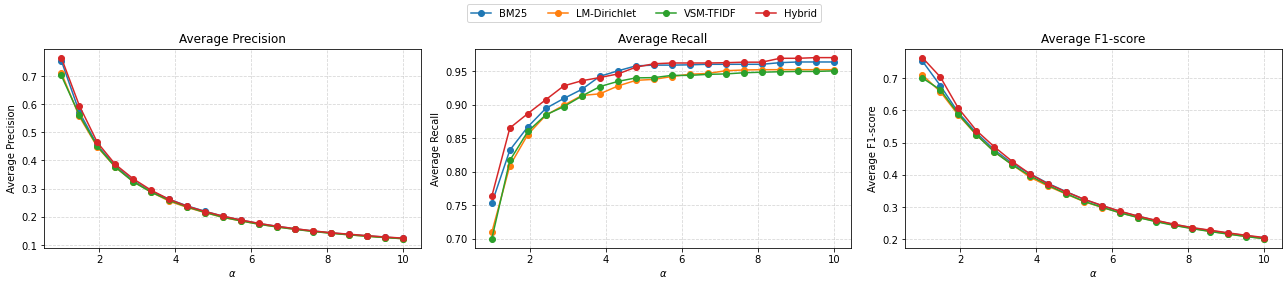

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharex=True)

for ax, metric in zip(axes, metrics):
    for name, res in model_results.items():
        ax.plot(res["alpha"], res[metric], marker="o", label=name)
    ax.set_xlabel(r"$\alpha$")
    ax.set_ylabel(metric_labels[metric])
    ax.set_title(metric_labels[metric])
    ax.grid(True, linestyle="--", alpha=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=4)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

### Numeric Comparison at a Few α Values

In [1]:
import pandas as pd

In [45]:
def results_at_alpha(model_results, alpha_target):
    """
    Return a dict: model -> (P, R, F1) for the closest alpha to alpha_target.
    """
    row = {}
    for name, res in model_results.items():
        alphas = np.array(res["alpha"])
        idx = int(np.argmin(np.abs(alphas - alpha_target)))
        row[name] = {
            "alpha": float(alphas[idx]),
            "precision": res["precision"][idx],
            "recall": res["recall"][idx],
            "f1": res["f1"][idx],
        }
    return row

for a in [2, 5, 8]:
    row = results_at_alpha(model_results, a)
    print(f"\n=== Metrics near alpha = {a} ===")
    df = pd.DataFrame(row).T[["alpha", "precision", "recall", "f1"]]
    display(df)


=== Metrics near alpha = 2 ===


,alpha,precision,recall,f1
BM25,1.947368,0.453724,0.866874,0.593363
LM-Dirichlet,1.947368,0.447838,0.855351,0.585571
VSM-TFIDF,1.947368,0.450238,0.859865,0.588706
Hybrid,1.947368,0.463836,0.886598,0.606732



=== Metrics near alpha = 5 ===


,alpha,precision,recall,f1
BM25,4.789474,0.218902,0.957729,0.347418
LM-Dirichlet,4.789474,0.214353,0.936134,0.339903
VSM-TFIDF,4.789474,0.215084,0.939829,0.341125
Hybrid,4.789474,0.218500,0.955778,0.346751



=== Metrics near alpha = 8 ===


,alpha,precision,recall,f1
BM25,8.105263,0.142693,0.960113,0.235369
LM-Dirichlet,8.105263,0.141691,0.952067,0.233587
VSM-TFIDF,8.105263,0.141214,0.948301,0.232739
Hybrid,8.105263,0.143085,0.963290,0.236066


## Results, Analysis, and Discussion

### Precision vs. α

For small values of α (around 1–2), all models achieve relatively high average precision (≈0.6–0.75).  
In this region:

- **Hybrid** has the best precision, e.g. near α ≈ 2 its precision is about **0.464**, slightly higher than BM25 (**0.454**) and the other two models.
- **BM25** is consistently the second–best or tied with Hybrid.
- **LM-Dirichlet** and **VSM-TFIDF** are very close to each other and slightly below BM25/Hybrid.

As α increases, the number of retrieved documents grows and **precision decreases monotonically** for all models, dropping to around **0.13–0.15** by α ≈ 10. The four curves stay very close together in this regime, but Hybrid and BM25 remain on top with only small gaps between the models. This behavior matches the expectation that retrieving more documents introduces more non-relevant items and therefore lowers precision.


### Recall vs. α

Average recall starts around **0.70–0.76** at α ≈ 1 and **increases rapidly** as α grows:

- By α ≈ 2, recall is already in the **0.85–0.90** range.
- From α ≈ 4 onwards, all models reach recall above **0.93**, and by α ≈ 10 they are near **0.95–0.97**.

Across almost the entire α range, **Hybrid clearly dominates in recall**. For example:

- Near α ≈ 2: Hybrid recall ≈ **0.887**, higher than BM25 (**0.867**), VSM (**0.860**), and LM-Dirichlet (**0.855**).
- Near α ≈ 5 and 8: Hybrid recall remains slightly above the others (≈ **0.96**), with BM25 close behind and VSM / LM a bit lower.

This means Hybrid is better at including relevant documents in its ranked list as we retrieve more documents, while the other models tend to miss a few more relevant items.


### F1-score vs. α

Because F1 combines precision and recall, it reflects both the quick increase in recall and the steady drop in precision:

- At small α, F1 is relatively high (≈0.7–0.76 for α ≈ 1).
- As α increases, **F1 decreases almost monotonically**, moving from around **0.60** at α ≈ 2 to about **0.20–0.23** by α ≈ 10.

In all tested α values, **Hybrid has the highest F1**, with BM25 as a close second:

- Near α ≈ 2: Hybrid F1 ≈ **0.607**, BM25 ≈ **0.593**, VSM ≈ **0.589**, LM ≈ **0.586**.
- Near α ≈ 5: Hybrid F1 ≈ **0.347**, slightly above BM25 (**0.347**, almost tied), and higher than VSM (**0.341**) and LM (**0.340**).
- Near α ≈ 8: Hybrid F1 ≈ **0.236**, again above BM25 (**0.235**), VSM (**0.233**), and LM (**0.234**).

The fact that F1 is highest at the smallest α values in this experiment suggests that once recall passes roughly 0.9 (which happens by α ≈ 3–4), further increases in recall add relatively little, while precision continues to drop, so F1 is dominated by the precision loss.


### Overall Comparison

Putting all three metrics together:

- **BM25** performs very strongly, especially in the top of the ranking, and is almost always the second–best model in terms of precision, recall, and F1.
- **LM-Dirichlet** and **VSM-TFIDF** behave similarly and are consistently just below BM25. They still achieve high recall at large α, but with slightly lower precision and F1.
- The **Hybrid model** is the best overall:
  - It has the **highest precision** at most α values.
  - It has the **highest recall** across almost the whole α range.
  - Consequently, it achieves the **highest F1-score** for all examined α values.

These results indicate that combining BM25, LM, and VSM scores into a hybrid model leads to a ranking that is more robust across different retrieval depths, effectively balancing the strengths of the individual models.